# Fisher Forecast with `focsle` 🧭

This notebook demonstrates how to use the `focsle` package to compute Fisher matrix forecasts for cosmological parameter constraints from strong lensing correlation functions.

## Installation

Before running this notebook, install the package in development mode. In your terminal, navigate to the `focsle` directory and run:

```bash
pip install -e .
```

This only needs to be done once (or when dependencies change).

In [1]:
from pathlib import Path

from focsle import FisherForecast, list_available_datasets
from focsle.plotting import plot_constraints, plot_comparison, print_constraints_table

import matplotlib.pyplot as plt
%matplotlib inline

JAX running on: [CudaDevice(id=0)]


## Configuration

Set the paths to your data. You need to specify:
1. `DATA_ROOT`: The root directory containing all dataset folders
2. `LENS_FILE`: Path to the Euclid lens catalogue file

In [2]:
# Path to the root data directory containing dataset folders
DATA_ROOT = '/home/nataliehogg/Documents/Projects/6x2pt/loscov_fork/data'

# Path to the Euclid lens catalog
LENS_FILE = '/home/nataliehogg/Documents/Projects/6x2pt/focsle/data/Euclid_lenses.txt'

# Output directory for results
RESULTS_DIR = Path.cwd().parent / 'results'

## List Available Datasets

Let's see what datasets are available in the data directory.

In [3]:
# List all available datasets
datasets = list_available_datasets(DATA_ROOT)

print("Available datasets:")
print("=" * 70)
for i, ds in enumerate(datasets, 0):
    print(f"{i}. {ds}")

Available datasets:
0. Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e3
1. Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e6
2. Nlens=1e5_sigL=0.05_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e5
3. Nlens=1e5_sigL=0.05_Nbin_z=6_SNR_goal=8_Nbin_max=20_nsamp=1e3
4. Nlens=1e5_sigL=0.05_Nbin_z=6_SNR_goal=8_Nbin_max=20_nsamp=1e6


## Select a Dataset

Choose which dataset to use for the forecast. You can either:
- Select by index from the list above
- Specify the full dataset name directly

In [4]:
# Option 1: Select by index
DATASET_INDEX = 0  # Change this to select a different dataset

# Get the dataset name
DATASET_NAME = datasets[DATASET_INDEX]
DATA_DIR = Path(DATA_ROOT) / DATASET_NAME

print(f"Selected dataset: {DATASET_NAME}")

Selected dataset: Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e3


## Initialise the Fisher Forecast

Create a `FisherForecast` object with the selected dataset.

In [5]:
# Initialise the forecast
forecast = FisherForecast(
    data_dir=str(DATA_DIR),
    lens_file=LENS_FILE,
    verbose=True
)

Detected 1 tomographic bins from data
Dataset parameters: {'Nlens': 10000.0, 'sigL': 0.1, 'z': 1, 'goal': 8, 'max': 20, 'nsamp': 1000.0}
Loaded 15999 lenses from /home/nataliehogg/Documents/Projects/6x2pt/focsle/data/Euclid_lenses.txt


## Setup the P(k) Grid

This is the computationally expensive step. CAMB computes the matter power spectrum at multiple cosmologies to build an interpolation grid.

**Note:** This can take several minutes. Adjust `nOm` and `nAs` to trade off accuracy vs. speed.

In [7]:
theta_min = 0.5 # minimum angular scale, 2.0 for KiDS Legacy, 0.5 for KiDS-1000, None for none

grid = 'coarse'

if grid == 'coarse':
    gridding = 3
elif grid == 'medium':
    gridding = 5
elif grid == 'fine':
    gridding = 10
else:
    print('Using default low-accuracy gridding.')
    gridding = 3

In [8]:
forecast.setup(
    nOm=gridding,  # Number of Omega_m grid points
    nAs=gridding,  # Number of A_s grid points
    nz=50,  # Number of redshift points
    nk=100, # Number of wavenumber points
    theta_min_arcmin=theta_min, 
)

Setting up Fisher Forecast

Setting up P(k) grid (this will take several minutes)...

Pre-computing CAMB P(k) grid...
  Omega_m range: (0.25, 0.4), 3 points
  A_s range: (1.5e-09, 2.7e-09), 3 points
Note: redshifts have been re-sorted (earliest first)
    Computed (1/3, 1/3): Omega_m=0.250, A_s=1.500e-09, sigma_8=0.570
Note: redshifts have been re-sorted (earliest first)
    Computed (1/3, 2/3): Omega_m=0.250, A_s=2.100e-09, sigma_8=0.675
Note: redshifts have been re-sorted (earliest first)
    Computed (1/3, 3/3): Omega_m=0.250, A_s=2.700e-09, sigma_8=0.765
Note: redshifts have been re-sorted (earliest first)
    Computed (2/3, 1/3): Omega_m=0.325, A_s=1.500e-09, sigma_8=0.705
Note: redshifts have been re-sorted (earliest first)
    Computed (2/3, 2/3): Omega_m=0.325, A_s=2.100e-09, sigma_8=0.834
Note: redshifts have been re-sorted (earliest first)
    Computed (2/3, 3/3): Omega_m=0.325, A_s=2.700e-09, sigma_8=0.945
Note: redshifts have been re-sorted (earliest first)
    Computed (3/

## Compute Fisher Matrices

Now we compute the Fisher matrices for each probe (LL, LE, LP) and the combined constraint.

In [9]:
# Compute Fisher matrices
results = forecast.compute_fisher()


Computing Fisher Matrices

Fiducial: Omega_m = 0.3131, sigma_8 = 0.8111

Computing Jacobian with JAX autodiff...
  (this may take a minute)
  Jacobian shape: (56, 2)
  Done!

--------------------------------------------------
Computing Fisher matrices for individual probes
--------------------------------------------------

1. LL only:
   sigma(Omega_m) = 0.0953 (30.4%)
   sigma(sigma_8) = 0.0838 (10.3%)

2. LE only:
   sigma(Omega_m) = 0.0121 (3.9%)
   sigma(sigma_8) = 0.0048 (0.6%)

3. LP only:
   sigma(Omega_m) = 0.0060 (1.9%)
   sigma(sigma_8) = 0.0013 (0.2%)

4. Combined (LL + LE + LP):
   sigma(Omega_m) = 0.0044 (1.4%)
   sigma(sigma_8) = 0.0009 (0.1%)
   Correlation: 0.215

Fisher computation complete!


## View Results

Let's print a summary table of the constraints.

In [10]:
# Print constraints summary table
print_constraints_table(results)


Parameter Constraints Summary
Fiducial: Omega_m = 0.3131, sigma_8 = 0.8111
----------------------------------------------------------------------
Probe        sigma(Om)    %(Om)      sigma(s8)    %(s8)      corr    
----------------------------------------------------------------------
LL           0.0953       30.4       0.0838       10.3       -0.214  
LE           0.0121       3.9        0.0048       0.6        -0.882  
LP           0.0060       1.9        0.0013       0.2        0.329   
Combined     0.0044       1.4        0.0009       0.1        0.215   


## Plot Constraints

Visualize the parameter constraints as ellipses in the Omega_m - sigma_8 plane.

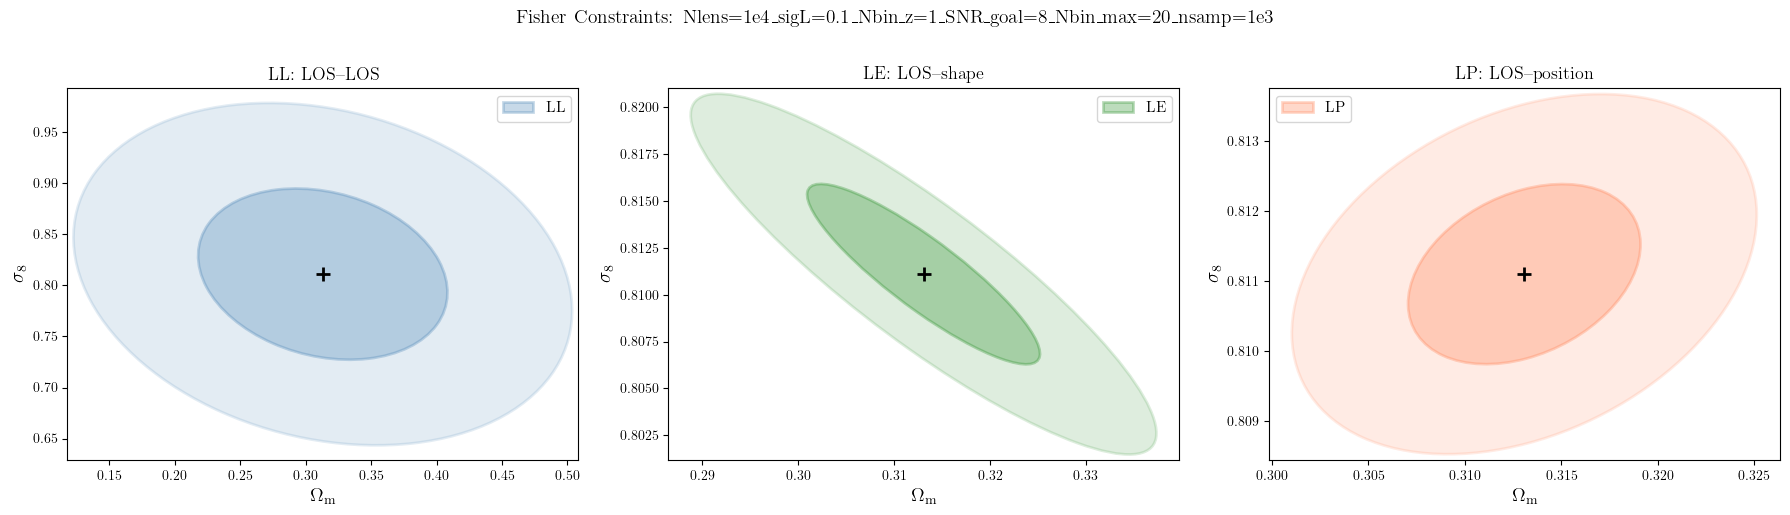

In [11]:
# Plot individual probe constraints
fig = plot_constraints(
    results,
    probes=['LL', 'LE', 'LP'],
    title=f'Fisher Constraints: {DATASET_NAME}',
    figsize=(18, 5)
)
plt.show()

## Save Results

Save the computed Fisher matrices for later use.

In [12]:
# Create results directory if it doesn't exist
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Save results
output_file = RESULTS_DIR / f'fisher_results_{DATASET_NAME}_scalecut={theta_min}_gridding={gridding}.pkl'
forecast.save_results(str(output_file))


Results saved to /home/nataliehogg/Documents/Projects/6x2pt/focsle/results/fisher_results_Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e3_scalecut=0.5_gridding=3.pkl


## Load and Compare Multiple Results

If you have run forecasts for multiple datasets, you can compare them.

In [13]:
saved_results = FisherForecast.list_saved_results()
for i, name in enumerate(saved_results, 0):
  print(f"{i}. {name}")

0. fisher_results_Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e3_scalecut=0.5.pkl
1. fisher_results_Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e3_scalecut=0.5_gridding=3.pkl
2. fisher_results_Nlens=1e4_sigL=0.1_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e6_scalecut=0.5.pkl
3. fisher_results_Nlens=1e5_sigL=0.05_Nbin_z=1_SNR_goal=8_Nbin_max=20_nsamp=1e5_scalecut=0.5.pkl
4. fisher_results_Nlens=1e5_sigL=0.05_Nbin_z=6_SNR_goal=8_Nbin_max=20_nsamp=1e3_scalecut=0.5.pkl
5. fisher_results_Nlens=1e5_sigL=0.05_Nbin_z=6_SNR_goal=8_Nbin_max=20_nsamp=1e6_scalecut=0.5.pkl


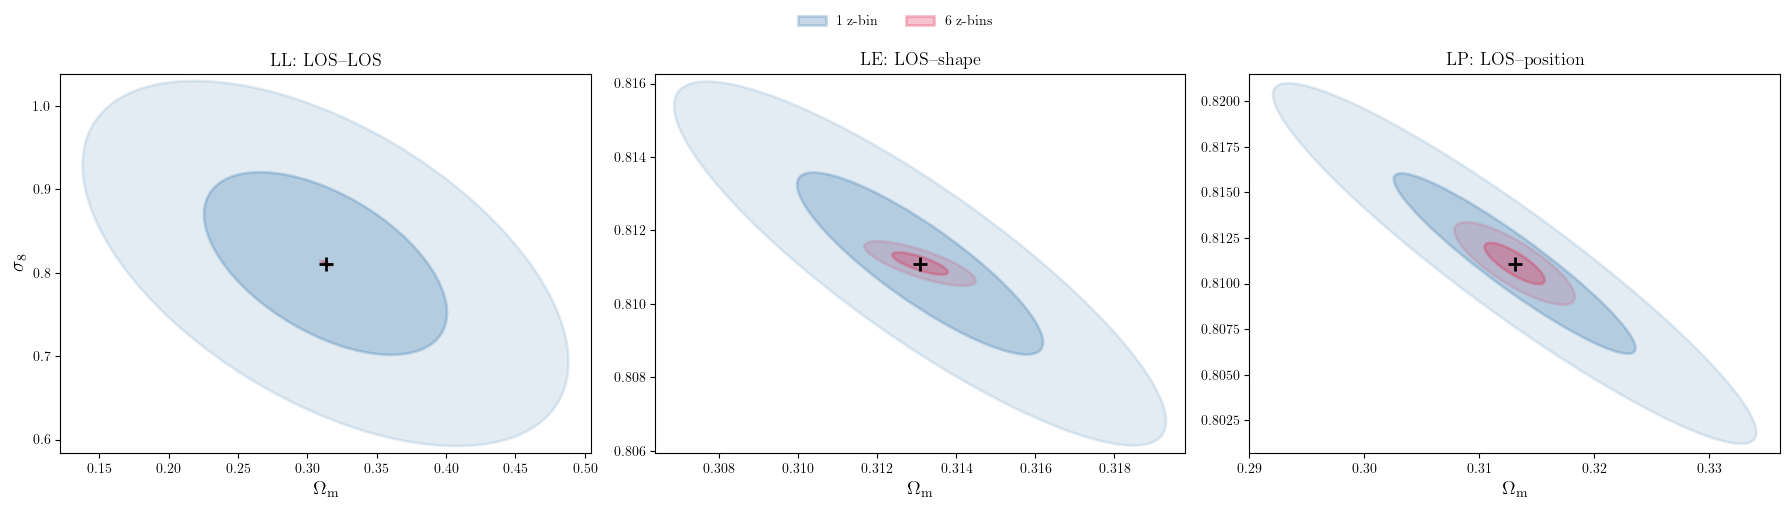

In [14]:
results_1zbin = FisherForecast.load_results(saved_results[2])
results_6zbin = FisherForecast.load_results(saved_results[5])

fig = plot_comparison(
    [results_1zbin, results_6zbin],
    labels=['1 z-bin', '6 z-bins'],
    probes=['LL', 'LE', 'LP'],
    title=None
)
plt.show()

## Figure of Merit

Compute and display the Figure of Merit (FoM) for each probe.

In [15]:
# Compute Figure of Merit for each probe
print("\nFigure of Merit (sqrt(det(F))):")
print("=" * 40)

for probe in ['LL', 'LE', 'LP', 'Combined']:
    try:
        fom = forecast.get_figure_of_merit(probe)
        print(f"{probe:<12}: {fom:.2e}")
    except (ValueError, KeyError):
        print(f"{probe:<12}: N/A")


Figure of Merit (sqrt(det(F))):
LL          : 1.28e+02
LE          : 3.63e+04
LP          : 1.37e+05
Combined    : 2.66e+05
